In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import datetime

import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
player_data = pd.read_excel('nba_player_data_2013_2016.xlsx')

# Step1: Construct individual player rating

## Calculate Correlation

In [20]:
player_data.corr()

,game_id,player_id,team_id,started,minutes,PTS,AST,REB,STL,days_since_last_game
game_id,1.000000,-0.024654,-0.030061,-0.002931,-0.005722,-0.007428,-0.018188,-0.005326,-0.012276,-0.000214
player_id,-0.024654,1.000000,0.033000,-0.080823,-0.084372,-0.060743,-0.054417,-0.044637,-0.030260,0.006738
team_id,-0.030061,0.033000,1.000000,-0.003149,-0.006171,-0.012965,-0.028331,0.001821,-0.013647,-0.001473
started,-0.002931,-0.080823,-0.003149,1.000000,0.666276,0.486717,0.351421,0.410558,0.256672,-0.059309
minutes,-0.005722,-0.084372,-0.006171,0.666276,1.000000,0.735573,0.511981,0.541747,0.385802,-0.085897
PTS,-0.007428,-0.060743,-0.012965,0.486717,0.735573,1.000000,0.423667,0.421866,0.316424,-0.052832
AST,-0.018188,-0.054417,-0.028331,0.351421,0.511981,0.423667,1.000000,0.147007,0.309179,-0.036870
REB,-0.005326,-0.044637,0.001821,0.410558,0.541747,0.421866,0.147007,1.000000,0.166388,-0.046367
STL,-0.012276,-0.030260,-0.013647,0.256672,0.385802,0.316424,0.309179,0.166388,1.000000,-0.028307
days_since_last_game,-0.000214,0.006738,-0.001473,-0.059309,-0.085897,-0.052832,-0.036870,-0.046367,-0.028307,1.000000


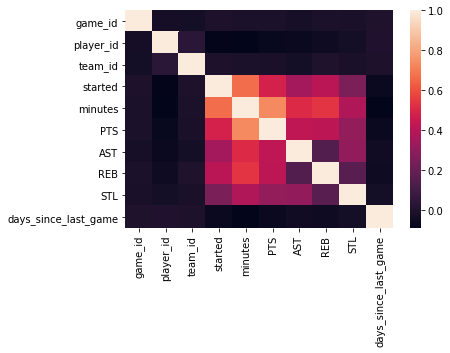

In [24]:
corr = player_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [26]:
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,game_id,player_id,team_id,started,minutes,PTS,AST,REB,STL,days_since_last_game
game_id,1,-0.0247,-0.0301,-0.00293,-0.00572,-0.00743,-0.0182,-0.00533,-0.0123,-0.000214
player_id,-0.0247,1,0.033,-0.0808,-0.0844,-0.0607,-0.0544,-0.0446,-0.0303,0.00674
team_id,-0.0301,0.033,1,-0.00315,-0.00617,-0.013,-0.0283,0.00182,-0.0136,-0.00147
started,-0.00293,-0.0808,-0.00315,1,0.666,0.487,0.351,0.411,0.257,-0.0593
minutes,-0.00572,-0.0844,-0.00617,0.666,1,0.736,0.512,0.542,0.386,-0.0859
PTS,-0.00743,-0.0607,-0.013,0.487,0.736,1,0.424,0.422,0.316,-0.0528
AST,-0.0182,-0.0544,-0.0283,0.351,0.512,0.424,1,0.147,0.309,-0.0369
REB,-0.00533,-0.0446,0.00182,0.411,0.542,0.422,0.147,1,0.166,-0.0464
STL,-0.0123,-0.0303,-0.0136,0.257,0.386,0.316,0.309,0.166,1,-0.0283
days_since_last_game,-0.000214,0.00674,-0.00147,-0.0593,-0.0859,-0.0528,-0.0369,-0.0464,-0.0283,1


### Add Season Column

In [3]:
def season_func(s):
    x1 = pd.Timestamp('2013-10-01')
    x2 = pd.Timestamp('2014-7-01')
    y1 = pd.Timestamp('2014-10-01')
    y2 = pd.Timestamp('2015-7-01')
    z1 = pd.Timestamp('2015-10-01')
    z2 = pd.Timestamp('2016-7-01')
    
    if (s['date'] >= x1) & (s['date'] <= x2) :
        return 1
    elif (s['date'] >= y1) & (s['date'] <= y2) :
        return 2
    elif (s['date'] >= z1) & (s['date'] <= z2) :
        return 3
    else:
        return np.nan

In [4]:
player_data['season'] = player_data.apply(season_func,axis=1 )

## Calculate Ratings

### 1. Win Score
#### Win Score Formula=(Points)+(Rebounds)+(Steals)+(½Assists)+(½Blocked Shots)-(Field Goal Attempts)-(Turnovers)-½(Free Throw Attempts)-½Personal Fouls

In [5]:
player_data['win_score']= player_data['PTS']+player_data['STL']+player_data['REB']+0.5*player_data['AST']

### 2. Win Score Adjusted by mins

In [6]:
player_data['win_score_byMins']= (player_data['PTS']+player_data['STL']+player_data['REB']
                                          +0.5*player_data['AST'])/player_data['minutes']


### 3. simple rating system (only looking at points)

In [7]:
player_data['simple_pts'] = (player_data['PTS'] - np.mean(player_data['PTS']))/np.mean(player_data['PTS'])
                                                                                              

In [8]:
np.mean(player_data['PTS'])

9.60713682534321

### GroupBy Player and Season

In [9]:
player_group = player_data.groupby(['full_name','season'])

In [10]:
ratings = player_group[['win_score','win_score_byMins','simple_pts']].mean()
ratings.columns = [['rating1','rating2','rating3']]
ratings

rating1   rating2   rating3
full_name           season                               
AJ Price            1        2.196429  0.603374 -0.836431
                    2        7.500000  0.467911 -0.467543
Aaron Brooks        1       13.243056  0.533725 -0.067533
                    2       14.734043  0.677547  0.116191
                    3       10.318841  0.617700 -0.259307
Aaron Gordon        2        9.563830  0.562240 -0.461836
                    3       17.506494  0.725284 -0.028049
Aaron Gray          1        5.291667  0.595170 -0.823626
Aaron Harrison      3        1.782609  0.384306 -0.918539
Adonis Thomas       1        3.083333  0.430778 -0.757125
Adreian Payne       2       12.781250  0.536411 -0.307156
                    3        5.259615  0.513232 -0.735773
Al Harrington       1        8.937500  0.580338 -0.391078
Al Horford          1       29.206897  0.882916  0.931036
                    2       25.016304  0.811627  0.569259
                    3       24.684783  0.766134  0.564733
Al Jefferson        1       34.400000  0.980400  1.253880
                    2       26.669231  0.857634  0.732686
                    3       19.851852  0.830282  0.262564
Al-Farouq Aminu     1       15.087500  0.588656 -0.255762
                    2       12.132911  0.666871 -0.383370
                    3       18.849462  0.636993  0.119240
Alan Anderson       1       10.438202  0.446130 -0.274884
                    2       11.762500  0.483311 -0.205018
                    3        7.923077  0.551052 -0.479554
Alan Williams       3        7.944444  0.976975 -0.676167
Alec Burks          1       19.500000  0.685340  0.453247
                    2       20.222222  0.606073  0.441829
                    3       18.403226  0.708437  0.383380
Alex Kirk           2        1.100000  0.401385 -0.916729
...                               ...       ...       ...
Wesley Johnson      1       15.329114  0.519674 -0.057926
                    2       15.697368  0.533764  0.031306
                    3       11.005814  0.528921 -0.316158
Wesley Matthews     1       21.833333  0.636591  0.682217
                    2       22.075000  0.655683  0.658489
                    3       17.596386  0.513257  0.306759
Will Barton         1        6.770833  0.660515 -0.542441
                    2       11.163793  0.636676 -0.287527
                    3       22.274390  0.762824  0.495331
Will Bynum          1       13.053571  0.670407 -0.098512
                    2        6.350000  0.424731 -0.573234
Will Cherry         2        3.750000  0.420358 -0.804833
Willie Cauley-Stein 3       13.338462  0.605997 -0.271375
Willie Green        1        6.891667  0.459740 -0.517720
                    2        8.557692  0.466188 -0.387475
Willie Reed         3        8.076923  0.714754 -0.514250
Wilson Chandler     1       20.048387  0.647925  0.420315
                    2       21.602564  0.687038  0.447909
Xavier Henry        1       14.313953  0.638820  0.045734
                    2        3.166667  0.314918 -0.768690
Xavier Munford      3        9.941176  0.551691 -0.406079
Zach LaVine         2       15.375000  0.596329  0.054589
                    3       19.176829  0.686788  0.459789
Zach Randolph       1       29.341176  0.837557  0.813603
                    2       28.268293  0.859069  0.669237
                    3       24.645833  0.822062  0.578687
Zaza Pachulia       1       16.250000  0.637989 -0.195310
                    2       17.205128  0.712805 -0.152606
                    3       19.345679  0.727173 -0.122309
Zoran Dragic        2        2.531250  0.377353 -0.817844

[1450 rows x 3 columns]

In [11]:
player_ratings = player_data.merge(ratings,on=['full_name','season'],how='left')

In [12]:
player_ratings= player_ratings.rename(columns={('rating1',): "rating1", ('rating2',): "rating2",('rating3',):"rating3"})

In [13]:
player_ratings

,date,game_id,player_id,first_name,last_name,full_name,team_id,team_name,started,minutes,...,REB,STL,days_since_last_game,season,win_score,win_score_byMins,simple_pts,rating1,rating2,rating3
0,2014-10-29,21400010,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,23.650000,...,2,1,5,2,19.0,0.803383,0.353161,14.734043,0.677547,0.116191
1,2014-10-31,21400022,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,19.716667,...,1,1,2,2,14.0,0.710059,0.144982,14.734043,0.677547,0.116191
2,2014-11-01,21400035,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,22.800000,...,2,0,1,2,20.5,0.899123,0.665429,14.734043,0.677547,0.116191
3,2014-11-04,21400053,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,29.850000,...,2,0,3,2,19.0,0.636516,0.353161,14.734043,0.677547,0.116191
4,2014-11-05,21400062,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,13.350000,...,3,0,1,2,5.5,0.411985,-0.791821,14.734043,0.677547,0.116191
5,2014-11-07,21400073,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,16.550000,...,1,1,2,2,14.0,0.845921,0.040893,14.734043,0.677547,0.116191
6,2014-11-08,21400086,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,28.183333,...,0,0,1,2,30.0,1.064459,1.706321,14.734043,0.677547,0.116191
7,2014-11-10,21400101,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,11.083333,...,2,2,2,2,14.5,1.308271,0.040893,14.734043,0.677547,0.116191
8,2014-11-13,21400119,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,9.433333,...,0,0,3,2,0.0,0.000000,-1.000000,14.734043,0.677547,0.116191
9,2014-11-15,21400135,201166,Aaron,Brooks,Aaron Brooks,1610612741,Bulls,0,17.850000,...,2,0,2,2,8.5,0.476190,-0.375464,14.734043,0.677547,0.116191


In [14]:
player_ratings.to_csv('nba_player_data_withRatings.csv')

In [1]:
import pandas as pd
import numpy as np

In [2]:
#df = pd.read_excel('nba_team_data_2013_2016.xlsx')

In [3]:
#df_p = pd.read_csv('nba_player_data_withRatings.csv')

# Step 2: Player - Team rating match

## 1. Get rating of each player in each season
<li> Here rating2 is used, since we think player points are correlated with minutes. rating2 is in a sense of "unit points".

In [5]:
df_2= df_p[["full_name","team_name","season","rating2"]]

In [6]:
df_2 = df_2.drop_duplicates() 

In [19]:
df_2[:20]

,full_name,team_name,season,rating2
0,Aaron Brooks,Bulls,2,0.677547
94,Aaron Brooks,Bulls,3,0.617700
163,Aaron Brooks,Nuggets,1,0.533725
192,Aaron Brooks,Rockets,1,0.533725
235,Aaron Gordon,Magic,2,0.562240
282,Aaron Gordon,Magic,3,0.725284
359,Aaron Gray,Kings,1,0.595170
392,Aaron Gray,Raptors,1,0.595170
395,Aaron Harrison,Hornets,3,0.384306
418,Adonis Thomas,76ers,1,0.430778


# 2. Get rating of each team in each season
<li> team rating = mean average rating of each player in this team this season

In [8]:
team_season_rating = df_2.groupby(['team_name','season']).mean().reset_index()

In [20]:
team_season_rating[:20]

,team_name,season,rating2
0,76ers,1,0.571902
1,76ers,2,0.592293
2,76ers,3,0.616825
3,Bucks,1,0.608444
4,Bucks,2,0.585041
5,Bucks,3,0.576160
6,Bulls,1,0.535383
7,Bulls,2,0.616370
8,Bulls,3,0.628292
9,Cavaliers,1,0.551711


# 3. Map team ratings to original team data file

## 3.1 Create season column for each game 

In [10]:
def season_func(s):
    x1 = pd.Timestamp('2013-10-01')
    x2 = pd.Timestamp('2014-7-01')
    y1 = pd.Timestamp('2014-10-01')
    y2 = pd.Timestamp('2015-7-01')
    z1 = pd.Timestamp('2015-10-01')
    z2 = pd.Timestamp('2016-7-01')
    
    if (s['date'] >= x1) & (s['date'] <= x2) :
        return 1
    elif (s['date'] >= y1) & (s['date'] <= y2) :
        return 2
    elif (s['date'] >= z1) & (s['date'] <= z2) :
        return 3
    else:
        return np.nan

In [11]:
df['season'] = df.apply(season_func,axis=1 )

## 3.2 Add home and away team member quality rating columns for each game

In [13]:
df['home_quality_previous_season'] = np.nan

df['away_quality_previous_season'] = np.nan

In [14]:
for i in range(len(df)):
    season = df.iloc[i]['season']-1
    home_name = df.iloc[i]['home_team_name']
    away_name = df.iloc[i]['away_team_name']
    #print(game_id)
    try:
        df['home_quality_previous_season'].iloc[i] = team_season_rating[(team_season_rating['season'] == season)
                                              & (team_season_rating['team_name'] == home_name)]['rating2'].values[0]
    except:
        df['home_quality_previous_season'].iloc[i] = np.nan
    try:
        df['away_quality_previous_season'].iloc[i]= team_season_rating[(team_season_rating['season'] == season) 
                                              & (team_season_rating['team_name'] == away_name)]['rating2'].values[0]
    except:
        df['away_quality_previous_season'].iloc[i] = np.nan       


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
df

,game_id,date,home_team_id,away_team_id,home_team_name,away_team_name,home_pts,away_pts,overtime,home_possessions,...,away_assists,home_rebounds,away_rebounds,home_steals,away_steals,home_back_to_back,away_back_to_back,season,home_quality_previous_season,away_quality_previous_season
0,21300001,2013-10-29,1610612754,1610612753,Pacers,Magic,97,87,0,91.277,...,17,44,39,4,10,0,0,1,NaN,NaN
1,21300002,2013-10-29,1610612748,1610612741,Heat,Bulls,107,95,0,93.850,...,23,40,41,10,11,0,0,1,NaN,NaN
2,21300003,2013-10-29,1610612747,1610612746,Lakers,Clippers,116,103,0,102.067,...,27,52,40,8,11,0,0,1,NaN,NaN
3,21300004,2013-10-30,1610612739,1610612751,Cavaliers,Nets,98,94,0,90.202,...,24,48,37,7,8,0,0,1,NaN,NaN
4,21300005,2013-10-30,1610612755,1610612748,76ers,Heat,114,110,0,96.538,...,30,40,31,16,7,0,1,1,NaN,NaN
5,21300006,2013-10-30,1610612761,1610612738,Raptors,Celtics,93,87,0,90.355,...,15,48,33,9,10,0,0,1,NaN,NaN
6,21300007,2013-10-30,1610612765,1610612764,Pistons,Wizards,113,102,0,94.579,...,23,44,38,6,5,0,0,1,NaN,NaN
7,21300008,2013-10-30,1610612752,1610612749,Knicks,Bucks,90,83,0,90.701,...,19,34,31,12,10,0,0,1,NaN,NaN
8,21300009,2013-10-30,1610612745,1610612766,Rockets,Hornets,96,83,0,86.938,...,14,54,37,4,8,0,0,1,NaN,NaN
9,21300010,2013-10-30,1610612750,1610612753,Timberwolves,Magic,120,115,1,110.362,...,21,49,54,7,7,0,1,1,NaN,NaN


# 4. Export the file for models

In [16]:
#df.to_excel("team_data_for_model.xlsx", index = False)

# Step3: Modeling

## Random Forest

In [111]:
#df = pd.read_excel('team_data_for_model.xlsx').rename(columns={" away_pts": "away_pts"})

In [131]:
def game_season(date):
    if date.year == 2013 or (date.year == 2014 and date.month < 10): return "1"
    elif (date.year == 2014 and date.month >= 10) or (date.year == 2015 and date.month < 10): return "2"
    else: return "3"
    
def preprocess(data, nan_method = "drop", col = ["home_team_player_quality", "away_team_player_quality"]):
    # select all relevant columns for building models
    df["home_win"] = df.apply(lambda game: 1 if game.home_pts > game.away_pts else 0, axis=1)
    df["season"] = df["date"].apply(lambda x: game_season(x))
    columns = ["game_id", "home_back_to_back", "away_back_to_back", "home_win", "season"] + col
    data = df[columns]
     
    # deal with nan values
    if nan_method == "drop":
        data = data[data.notna().all(axis=1)]
    elif nan_method == "mean":
        data = data.fillna(value={col[0]: data[col[0]].mean(), col[1]: data1[col[1]].mean()})
    elif nan_method == "median":
        data = data.fillna(value={col[0]: data[col[0]].median(), col[1]: data1[col[1]].median()})
    else:
        return "Please enter valid method"
    
    # use difference of quality
    data["quality_diff"] = data[col[0]] - data[col[1]]
    data["home_better_quality"] = data["quality_diff"].apply(lambda x: 1 if x > 0 else 0)
    # back_to_back var
    data["back_to_back"] = data.apply(lambda game: 1 if game.home_back_to_back == game.away_back_to_back else 0, 
                                                                                          axis=1)
    train = data[data["season"] != "3"]
    test = data[data["season"] == "3"]
#     dataset = [train[["quality_diff", "back_to_back"]], train["home_win"], 
#                test[["quality_diff", "back_to_back"]], test["home_win"]]
    dataset = [train[["quality_diff"]], train["home_win"], 
               test[["quality_diff"]], test["home_win"]]
    return dataset


def evaluate_model(dataset):
    X_train, y_train, X_test, y_test = dataset
    clf = RandomForestClassifier(max_depth=3, n_estimators=110)
    clf.fit(X_train, y_train)
    prob = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    true = y_test
    fpr, tpr, thresholds = metrics.roc_curve(true, prob)
    auc = metrics.auc(fpr, tpr)
    accuracy = metrics.accuracy_score(true, pred)
    print("Accuracy is %s, AUC is %s" %(accuracy, auc))

In [133]:
# quality mapping 1
dataset1 = preprocess(df, "drop", ["home_team_player_quality", "away_team_player_quality"])
evaluate_model(dataset1)
# quality mapping 2
dataset2 = preprocess(df, "drop", ["home_team_player_quality2", "away_team_player_quality2"])
evaluate_model(dataset2)
# quality mapping 3
dataset3 = preprocess(df, "drop", ["home_team_player_quality3", "away_team_player_quality3"])
evaluate_model(dataset3)

Accuracy is 0.6149162861491628, AUC is 0.6194173893813819
Accuracy is 0.632420091324201, AUC is 0.6447031902005654
Accuracy is 0.6202435312024354, AUC is 0.6206673172701576


## Logistics Regression

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

In [4]:
# load data set from excel files
df = pd.read_excel('team_data_for_model.xlsx').rename(columns={" away_pts": "away_pts"})

In [13]:
def game_season(date):
    if date.year == 2013 or (date.year == 2014 and date.month < 10): return "1"
    elif (date.year == 2014 and date.month >= 10) or (date.year == 2015 and date.month < 10): return "2"
    else: return "3"
    
def preprocess(data, nan_method = "drop", col = ["home_quality_previous_season", "away_quality_previous_season"]):
    # select all relevant columns for building models
    df["home_win"] = df.apply(lambda game: 1 if game.home_pts > game.away_pts else 0, axis=1)
    df["season"] = df["date"].apply(lambda x: game_season(x))
    columns = ["game_id", "home_back_to_back", "away_back_to_back", "home_win", "season"] + col
    data = df[columns]
    
    
    # deal with nan values
    if nan_method == "drop":
        data = data[data.notna().all(axis=1)]
    elif nan_method == "mean":
        data = data.fillna(value={col[0]: data[col[0]].mean(), col[1]: data1[col[1]].mean()})
    elif nan_method == "median":
        data = data.fillna(value={col[0]: data[col[0]].median(), col[1]: data1[col[1]].median()})
    else:
        return "Please enter valid method"
    
    # use difference of quality
    data["quality_diff"] = data[col[0]] - data[col[1]]
    data["home_better_quality"] = data["quality_diff"].apply(lambda x: 1 if x > 0 else 0)
    # back_to_back var
    data["back_to_back"] = data.apply(lambda game: 1 if game.home_back_to_back == game.away_back_to_back else 0, 
                                                                                          axis=1)
    
    train = data[data["season"] == "2"]
    test = data[data["season"] == "3"]
    
    dataset = [train[[col[0], col[1], "home_back_to_back", "away_back_to_back"]], train["home_win"],
               test[[col[0], col[1], "home_back_to_back", "away_back_to_back"]], test["home_win"]]
    
    '''
    dataset = [train[["quality_diff", "back_to_back"]], train["home_win"], 
               test[["quality_diff", "back_to_back"]], test["home_win"]]
    dataset = [train[["quality_diff"]], train["home_win"], 
               test[["quality_diff"]], test["home_win"]]
    '''
    
    return dataset


def evaluate_model(dataset, method):
    X_train, y_train, X_test, y_test = dataset
    
    
    if method == "logistic":
        
        log = LogisticRegression()
        log.fit(X_train, y_train)
        prob = log.predict_proba(X_test)[:, 1]
        pred = log.predict(X_test)
        true = y_test
        fpr, tpr, thresholds = metrics.roc_curve(true, prob)
        auc = metrics.auc(fpr, tpr)
        accuracy = metrics.accuracy_score(true, pred)
        print("Accuracy is %s, AUC is %s" %(accuracy, auc))
    
    elif method == "svm":
        
        svc = SVC()
        svc.fit(X_train, y_train)
        
        pred = svc.predict(X_test)
        true = y_test
        
        accuracy = metrics.accuracy_score(true, pred)
        print("Accuracy is %s" %accuracy)

In [10]:
# logistic regression result
dataset1 = preprocess(df, "drop", ["home_quality_previous_season", "away_quality_previous_season"])
evaluate_model(dataset1, "logistic")


Accuracy is 0.5939265536723164, AUC is 0.48395802098950524


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
